In [14]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch


from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP
from micrograd.onehot import arr2vals, oh_encode, VOID
from micrograd.visualize import draw_dot

%matplotlib inline

In [15]:
def calc_accuracy(scores, targets, oh_decoder):
    matches = 0
    for score, target in zip(scores, targets):
        matches += oh_decoder(score) == oh_decoder(target)
    return matches / len(scores)


def one_loss(score, targets):
    assert len(score) == len(targets)
    out = sum([(s - t).abs() for s, t in zip(score, targets) if t.data != VOID], start=Value(0.0, _name='init loss'))
    out._name = f'one loss'
    return out


def calc_loss(scores, targets):
    assert len(scores) == len(targets)
    out = sum([one_loss(xs, ts) for xs, ts in zip(scores, targets)], start=Value(0.0, _name='init loss'))
    out._name = 'loss'
    return out


def feed_forward(model, X):
    return list(map(model, X))


def evaluate(model, X, Y_oh, oh_decoder):
    input = arr2vals(X, 'input')
    scores = feed_forward(model, input)
    targets = arr2vals(Y_oh, 'expected')
    return calc_loss(scores, targets), calc_accuracy(scores, targets, oh_decoder), scores, targets

In [16]:
np.random.seed(1337)
random.seed(1337)

CLASSES = [0]
oh_encoder, oh_decoder = oh_encode(CLASSES)

x = torch.tensor([
    [0]
])
y_oh = oh_encoder([0])

model = MLP(
    [
        Layer(
            [x.shape[1], y_oh.shape[1]],
            'sbin',
            lr=1.0,
            _lid=0,
            init=lambda: 0.0 # TODO: play with initial value
        )
    ]
)


input = arr2vals(x, 'input')
scores = feed_forward(model, input)
targets = arr2vals(y_oh, 'target')

print('inputs: ', x)
print('targets: ', y_oh, '\n')

total_loss = calc_loss(scores, targets)

def dump(k, model, total_loss=None, scores=None):
    print(f'{k} params: ', model.layers[0].parameters())
    if total_loss:
        print(f'{k} loss: ', total_loss)
    if scores:
        print(f'{k} scores: ', scores, '\n')

inputs:  tensor([[0]])
targets:  tensor([[1.]]) 



backward:loss:[grad <- 1]
backward:init loss:[grad <- 1.0]
backward:one loss:[grad <- 1.0]
backward:init loss:[grad <- 1.0]
backward:neg:auto:[grad <- 1.0]
backward:-1:[grad <- -1.0]
backward:auto:[grad <- -1.0]
backward:auto:[grad <- -1.0]
backward:auto:[grad <- -1.0]
backward:input:0:0:[grad <- 0.0]
backward:L0:n0:w0:[grad <- 0.0]
backward:L0:n0:b:[grad <- -1.0]
backward:neg:target:0:0:[grad <- -1.0]
backward:-1:[grad <- -1.0]
backward:target:0:0:[grad <- 1.0]


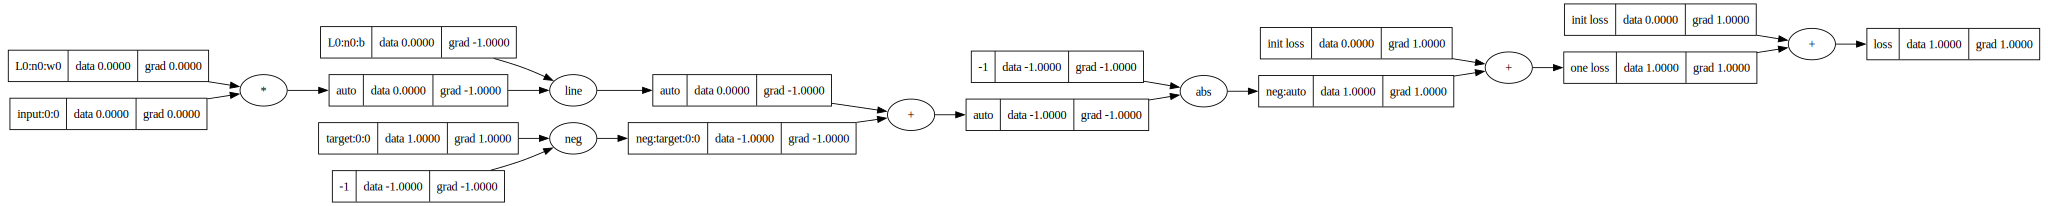

In [17]:
total_loss.backward(logging=True)
draw_dot(total_loss)

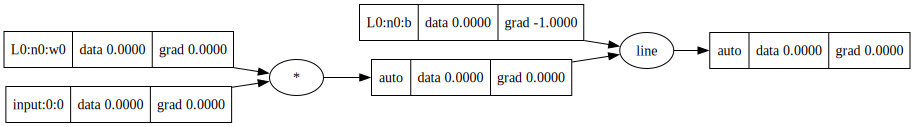

In [18]:
scores = feed_forward(model, input)
draw_dot(scores[0][0])

In [19]:
def learn_some(model, total_loss=None, iterations=1):
    dump('start', model)

    for k in range(iterations):
        if total_loss is not None:
            model.learn_from(total_loss, logging=True)

        scores = feed_forward(model, input)
        total_loss = calc_loss(scores, targets)

        dump(k, model, total_loss, scores)

    acc = calc_accuracy(scores, targets, oh_decoder)
    print(f'accuracy: {acc}')
    return total_loss, scores

start params:  [Value(L0:n0:w0 : [0.0, 0.0, 1.0]), Value(L0:n0:b : [0.0, -1.0, 1.0])]
backward:loss:[grad <- 1]
backward:init loss:[grad <- 1.0]
backward:one loss:[grad <- 1.0]
backward:init loss:[grad <- 1.0]
backward:neg:auto:[grad <- 1.0]
backward:-1:[grad <- -1.0]
backward:auto:[grad <- -1.0]
backward:auto:[grad <- -1.0]
backward:auto:[grad <- -1.0]
backward:input:0:0:[grad <- 0.0]
backward:L0:n0:w0:[grad <- 0.0]
backward:L0:n0:b:[grad <- -1.0]
backward:neg:target:0:0:[grad <- -1.0]
backward:-1:[grad <- -1.0]
backward:target:0:0:[grad <- 1.0]
learn:L0:n0:w0[data[0.0 <- 0.0+-0.0]
learn:L0:n0:b[data[1.0 <- 0.0+1.0]
0 params:  [Value(L0:n0:w0 : [0.0, 0.0, 1.0]), Value(L0:n0:b : [1.0, -1.0, 1.0])]
0 loss:  Value(loss : [0.0, 0.0, 1.0])
0 scores:  [[Value(auto : [1.0, 0.0, 1.0])]] 

accuracy: 1.0


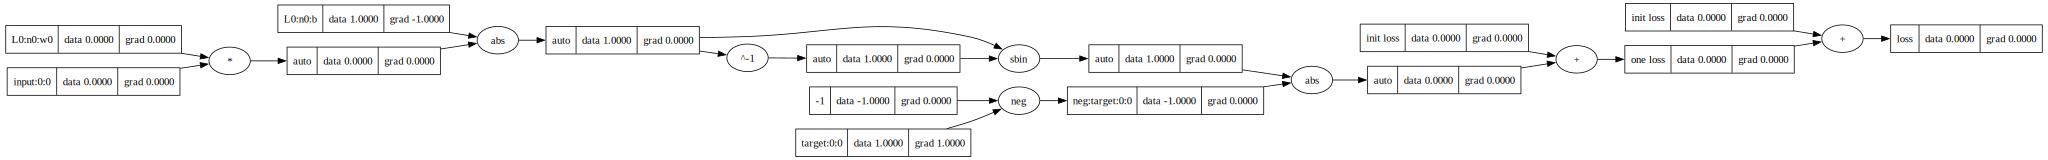

In [20]:
total_loss, scores = learn_some(model, total_loss)
draw_dot(total_loss)

backward:loss:[grad <- 1]
backward:init loss:[grad <- 1.0]
backward:one loss:[grad <- 1.0]
backward:auto:[grad <- 1.0]
backward:neg:target:0:0:[grad <- 1.0]
backward:-1:[grad <- 1.0]
backward:target:0:0:[grad <- -1.0]
backward:auto:[grad <- 1.0]
backward:auto:[grad <- 1.0]
backward:auto:[grad <- 0.0]
backward:L0:n0:b:[grad <- 0.0]
backward:auto:[grad <- 0.0]
backward:input:0:0:[grad <- 0.0]
backward:L0:n0:w0:[grad <- 0.0]
backward:init loss:[grad <- 1.0]
loss: 0.0


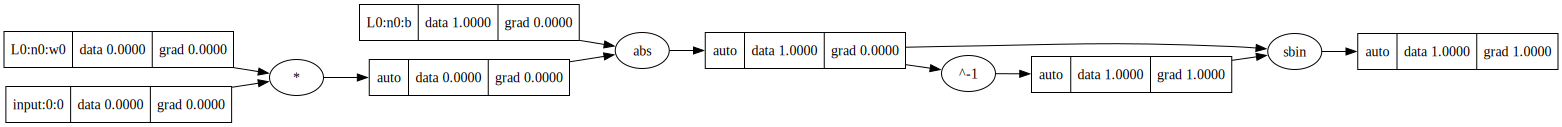

In [24]:
scores = feed_forward(model, input)
total_loss = calc_loss(scores, targets)
total_loss.backward(logging=True)
print(f'loss: {total_loss.data}')
draw_dot(scores[0][0])